In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import os
import torchattacks

print("Libraries imported.")

Libraries imported.


In [2]:
# Cell 2: Define Constants and Paths
# Paths (relative to the 'notebooks' folder)
DATA_DIR = "../data/processed"
MODEL_DIR = "../models"
TEST_FILE = os.path.join(DATA_DIR, "test.pt")
BASELINE_MODEL_PATH = os.path.join(MODEL_DIR, "cnn_classifier.pth")

# --- We need paths to BOTH autoencoders ---
# This is the old, simple one that was trained on clean data
FAILED_AE_PATH = os.path.join(MODEL_DIR, "autoencoder.pth") 
# This is the new, Denoising one
SUCCESSFUL_AE_PATH = os.path.join(MODEL_DIR, "denoising_autoencoder.pth")

# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
N_IMAGES = 5 # Number of images to show

print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Cell 3: Define All Helper Models and Functions

# Copied from src/model_zoo.py
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1); self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2); self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10); self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))); x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7); x = self.dropout(x)
        x = F.relu(self.fc1(x)); x = self.fc2(x); return x

# Copied from src/model_zoo.py
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc1 = nn.Conv2d(1, 16, 3, 1, 1); self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Conv2d(16, 32, 3, 1, 1); self.pool2 = nn.MaxPool2d(2, 2)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, 2); self.dec1 = nn.Conv2d(16, 16, 3, 1, 1)
        self.up2 = nn.ConvTranspose2d(16, 1, 2, 2); self.dec2 = nn.Conv2d(1, 1, 3, 1, 1)
    def forward(self, x):
        x = self.pool1(F.relu(self.enc1(x))); x = self.pool2(F.relu(self.enc2(x)))
        x = F.relu(self.dec1(F.relu(self.up1(x)))); x = torch.tanh(self.dec2(F.relu(self.up2(x))))
        return x

# Copied from src/visualize.py
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()
    mean = torch.tensor(mean).to(tensor.device); std = torch.tensor(std).to(tensor.device)
    if tensor.dim() == 4: mean=mean.view(1,-1,1,1); std=std.view(1,-1,1,1)
    elif tensor.dim() == 3: mean=mean.view(-1,1,1); std=std.view(-1,1,1)
    tensor.mul_(std).add_(mean); return torch.clamp(tensor, 0, 1)

print("Helper models and functions defined.")

Helper models and functions defined.


In [5]:
# Cell 4: Load Models and Data
try:
    classifier = BaseCNN().to(DEVICE)
    classifier.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=DEVICE))
    classifier.eval()
    print(f"Classifier loaded from {BASELINE_MODEL_PATH}")

    failed_ae = Autoencoder().to(DEVICE)
    failed_ae.load_state_dict(torch.load(FAILED_AE_PATH, map_location=DEVICE))
    failed_ae.eval()
    print(f"FAILED AE loaded from {FAILED_AE_PATH}")
    
    successful_ae = Autoencoder().to(DEVICE)
    successful_ae.load_state_dict(torch.load(SUCCESSFUL_AE_PATH, map_location=DEVICE))
    successful_ae.eval()
    print(f"SUCCESSFUL DAE loaded from {SUCCESSFUL_AE_PATH}")
    
    test_images, test_labels = torch.load(TEST_FILE)
    test_ds = TensorDataset(test_images, test_labels)
    test_loader = DataLoader(test_ds, batch_size=N_IMAGES, shuffle=True)
    clean_images, true_labels = next(iter(test_loader))
    clean_images, true_labels = clean_images.to(DEVICE), true_labels.to(DEVICE)
    print("Test batch loaded.")
    
except FileNotFoundError as e:
    print(f"---!!! ERROR: File not found! !!!---")
    print(e)
    print("Please make sure you have run all training scripts first.")

Classifier loaded from ../models\cnn_classifier.pth
FAILED AE loaded from ../models\autoencoder.pth
SUCCESSFUL DAE loaded from ../models\denoising_autoencoder.pth
Test batch loaded.


In [6]:
# Cell 5: Create Attack
fgsm_attack = torchattacks.FGSM(classifier, eps=0.3)
fgsm_attack.set_normalization_used(mean=MNIST_MEAN, std=MNIST_STD)
adv_images = fgsm_attack(clean_images, true_labels)
print("Adversarial images created.")

Adversarial images created.


In [7]:
# Cell 6: Plot Comparison Helper Function
def get_preds(model, imgs):
    with torch.no_grad():
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
    return preds.cpu().numpy()

def plot_comparison(clean_imgs, adv_imgs, purified_imgs, title_suffix, n):
    clean_preds = get_preds(classifier, clean_imgs)
    adv_preds = get_preds(classifier, adv_imgs)
    purified_preds = get_preds(classifier, purified_imgs)
    true_labels_np = true_labels.cpu().numpy()

    clean_imgs = unnormalize(clean_imgs.cpu(), MNIST_MEAN, MNIST_STD)
    adv_imgs = unnormalize(adv_imgs.cpu(), MNIST_MEAN, MNIST_STD)
    purified_imgs = unnormalize(purified_imgs.cpu(), MNIST_MEAN, MNIST_STD)
    
    plt.figure(figsize=(12, n * 3))
    for i in range(n):
        ax = plt.subplot(n, 3, 3*i + 1)
        plt.imshow(clean_imgs[i].squeeze(), cmap="gray")
        color = "green" if clean_preds[i] == true_labels_np[i] else "red"
        ax.set_title(f"Clean (True: {true_labels_np[i]})\nPred: {clean_preds[i]}", color=color)
        ax.axis("off")
        
        ax = plt.subplot(n, 3, 3*i + 2)
        plt.imshow(adv_imgs[i].squeeze(), cmap="gray")
        ax.set_title(f"Adversarial (FGSM)\nPred: {adv_preds[i]}", color="red")
        ax.axis("off")
        
        ax = plt.subplot(n, 3, 3*i + 3)
        plt.imshow(purified_imgs[i].squeeze(), cmap="gray")
        color = "green" if purified_preds[i] == true_labels_np[i] else "red"
        ax.set_title(f"Purified {title_suffix}\nPred: {purified_preds[i]}", color=color)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

--- Part 1: FAILED Purification (Simple AE) ---


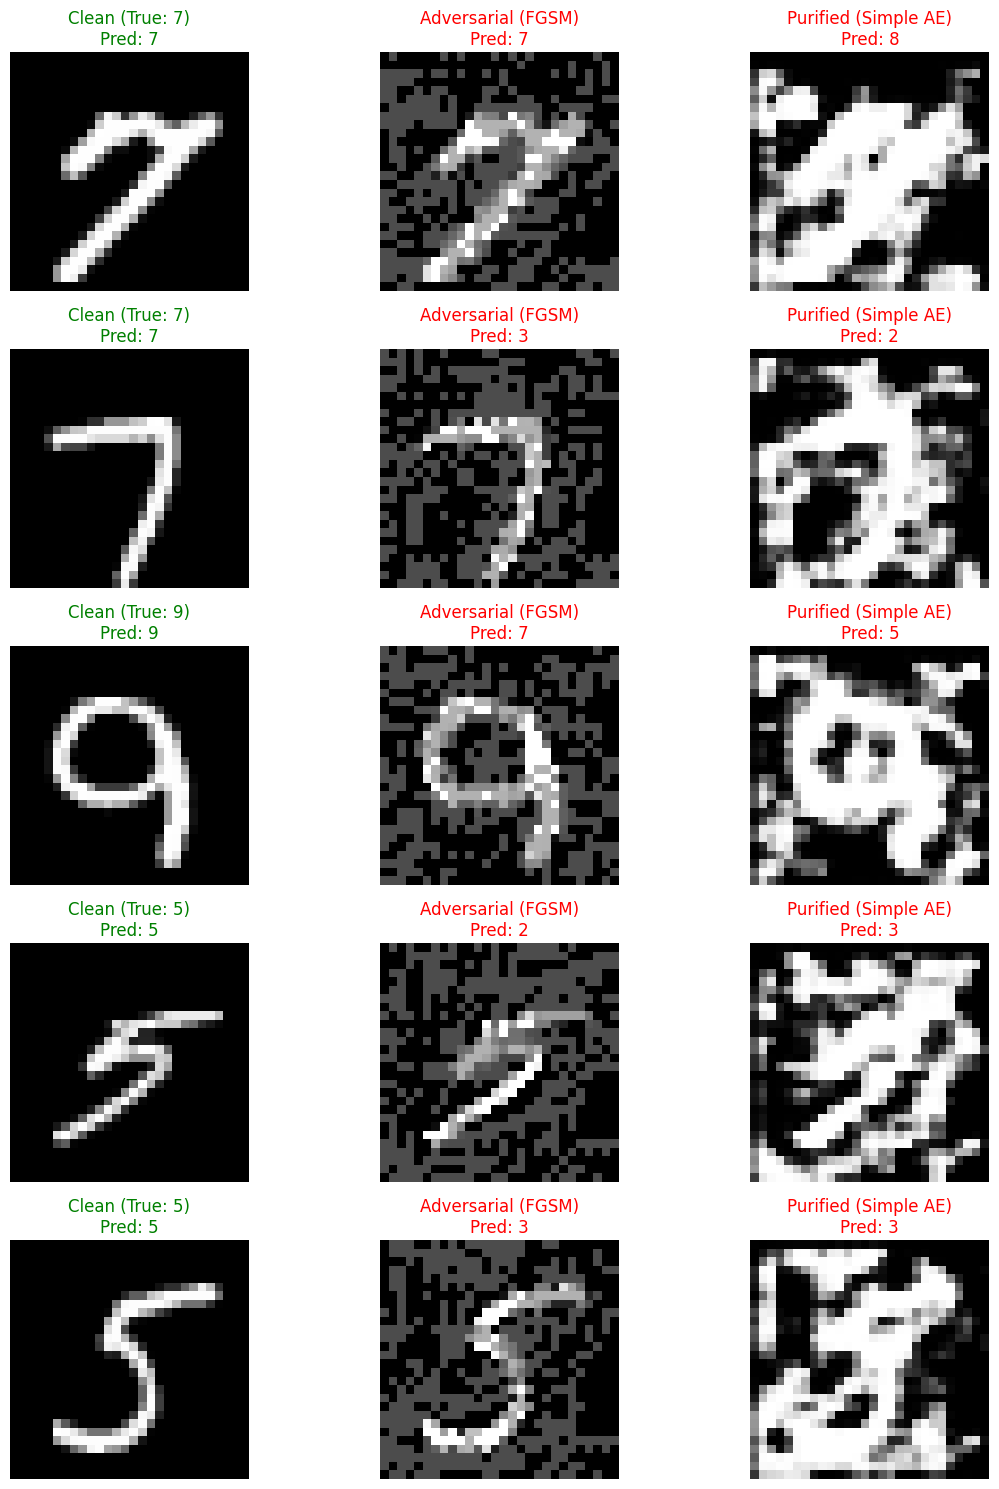

In [8]:
# Cell 7: Part 1 - Visualize FAILED Purification (Simple AE)
print("--- Part 1: FAILED Purification (Simple AE) ---")
with torch.no_grad():
    failed_purified_images = failed_ae(adv_images)
plot_comparison(clean_images, adv_images, failed_purified_images, "(Simple AE)", n=N_IMAGES)


--- Part 2: SUCCESSFUL Purification (Denoising AE) ---


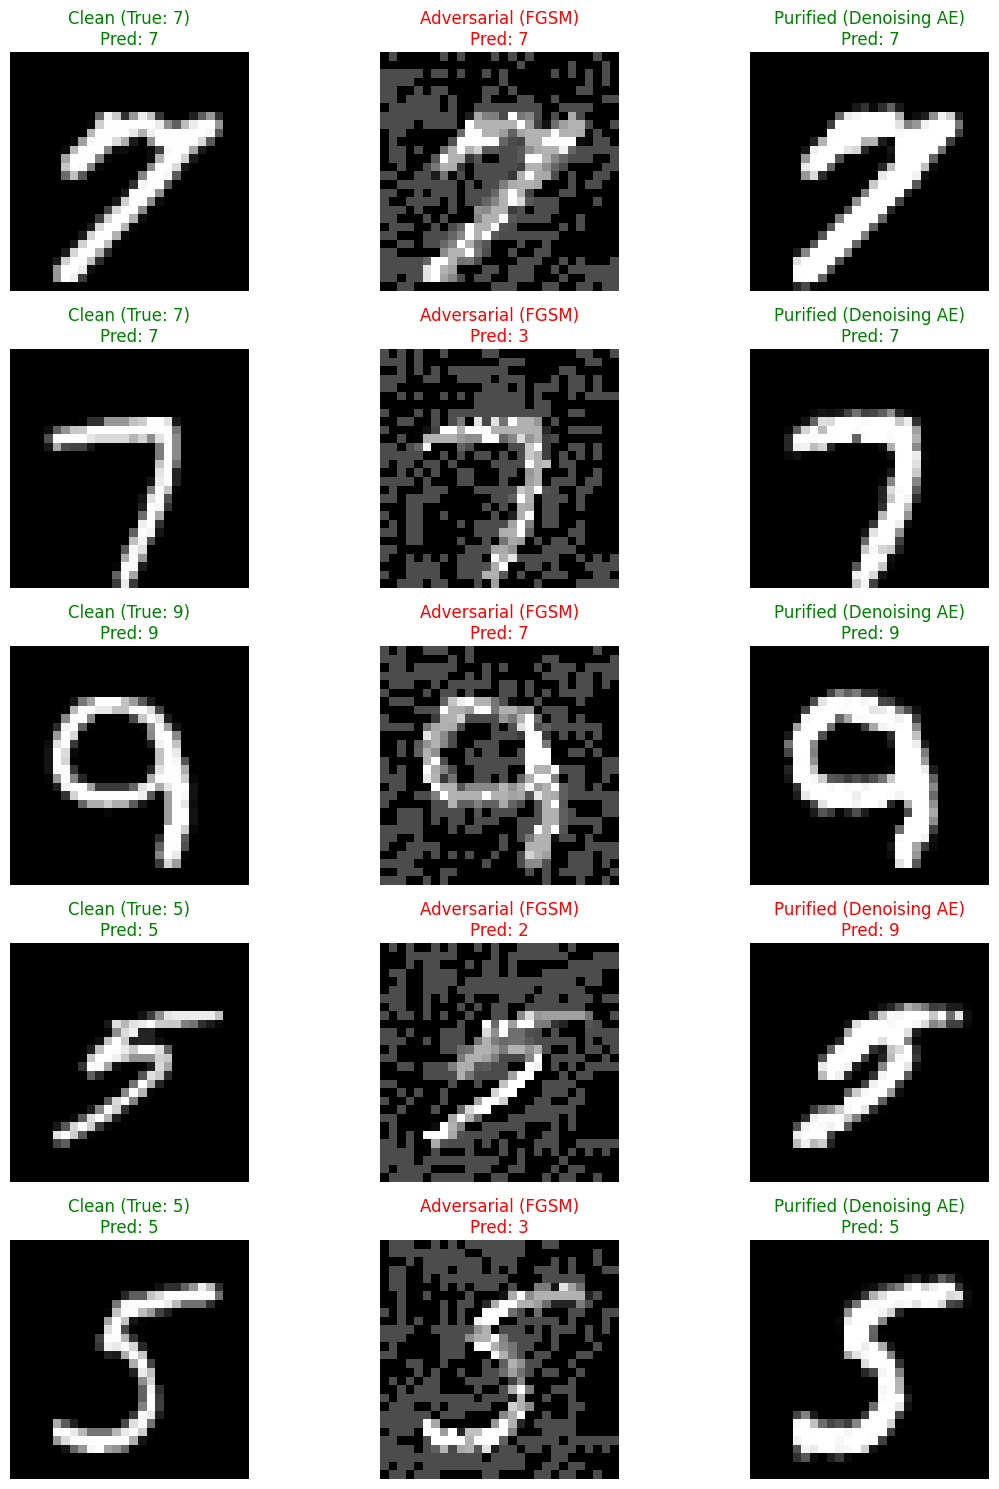

In [9]:
# Cell 8: Part 2 - Visualize SUCCESSFUL Purification (Denoising AE)
print("\n--- Part 2: SUCCESSFUL Purification (Denoising AE) ---")
with torch.no_grad():
    successful_purified_images = successful_ae(adv_images)
plot_comparison(clean_images, adv_images, successful_purified_images, "(Denoising AE)", n=N_IMAGES)